# Visualization of tremor catalog with altair

Import Python packages

In [1]:
import altair as alt
alt.renderers.enable('notebook')

import geopandas as gpd
import gpdvega
import json
import numpy as np
import pandas as pd

from shapely.geometry import Polygon

Define functions

In [2]:
def select_tremor(tremors, tbegin, tend, \
    latmin, latmax, lonmin, lonmax):
    """
    Select tremor within user-defined area and time range

    Input:
        type tremors = pandas dataframe
        tremors = {datetime, latitude, longitude, depth}
        type tbegin = datatime.datetime
        tbegin = Beginning of selected time interval
        type tend = datatime.datetime
        tend = End of selected time interval
        type latmin = float
        latmin = Southern boundary of selected region
        type latmax = float
        latmax = Northern boundary of selected region
        type latmin = float
        lonmin = Western boundary of selected region
        type latmin = float
        lonmax = Eastern boundary of selected region
    Output:
        type tremors = pandas dataframe
        tremors = {datetime, latitude, longitude, depth}
    """
    # Keep only tremors within a user-defined area
    if (latmin != None):
        tremors = tremors.loc[(tremors['latitude'] >= latmin)]
    if (latmax != None):
        tremors = tremors.loc[(tremors['latitude'] <= latmax)]
    if (lonmin != None):
        tremors = tremors.loc[(tremors['longitude'] >= lonmin)]
    if (lonmax != None):
        tremors = tremors.loc[(tremors['longitude'] <= lonmax)]
    # Keep only tremors within a user-defined time range
    if (tbegin !=None):
        mask = (tremors['datetime'] >= tbegin)
        tremors = tremors.loc[mask]
    if (tend != None):
        mask = (tremors['datetime'] <= tend)
        tremors = tremors.loc[mask]
    return tremors

In [3]:
def bin_tremor(tremors, nbin, winlen):
    """
    Compute the percentage of the time during which there is recorded tremor

    Input:
        type tremors = pandas dataframe
        tremors = {datetime, latitude, longitude, depth}
        type nbin = integer
        nbin = Duration of the time windows (in minutes) for which we compute
            the percentage of time with tremor
        type winlen = float
        winlen = Duration of the time windows from the tremor catalog
            (in minutes)
    Output:
        type dfInterp = pandas dataframe
        dfInterp = {datetime, latitude, longitude, depth, Time, Value}
    """
    # Bin tremor windows
    smin = str(nbin) + 'T'
    df = pd.DataFrame({'Time': tremors['datetime'], \
                       'Value': np.repeat(1, tremors.shape[0])})
    df.set_index('Time', inplace=True)
    df_group = df.groupby(pd.Grouper(level='Time', \
        freq=smin))['Value'].agg('sum')   
    df_group = df_group.to_frame().reset_index()
    df_group['Value'] = (winlen / nbin) * df_group['Value']
    # Merge datasets to keep the number of tremor windows
    dfInterp = pd.merge_asof(tremors.sort_values(by="datetime"), \
        df_group.sort_values(by="Time"), left_on="datetime", right_on="Time")
    return dfInterp

In [4]:
def read_background(filename, latmin, latmax, lonmin, lonmax):
    """
    Get a geodataframe with a background map

    Input:
        type filename = string
        filename = Shape file with background map
        type latmin = float
        latmin = Southern boundary of the map
        type latmax = float
        latmax = Northern boundary of the map
        type lonmin = float
        lonmin = Western boundary of the map
        type lonmax = float
        lonmax = Eastern boundary of the map
    Output:
        type subdata = geopandas dataframe
        subdata = background map
    """
    data = gpd.read_file(filename)
    data.rename(columns={'id' : 'id0'}, inplace=True)
    limits = gpd.GeoSeries([Polygon([(lonmin, latmin), (lonmax, latmin), \
        (lonmax, latmax), (lonmin, latmax)])])
    boundaries = gpd.GeoDataFrame({'geometry': limits, 'df':[1]}, crs=data.crs)
    subdata = gpd.overlay(data, boundaries, how='intersection')
    return subdata

Set parameters

In [5]:
filename = '../data/tremor.pkl'
winlen = 1.0
nbin =  1440
tbegin = None
tend = None
latmin = None
latmax = None
lonmin = None
lonmax = None

Preprocessing of data

In [6]:
# Read dataset
tremors = pd.read_pickle(filename)[0]
# Select tremors
tremors = select_tremor(tremors, tbegin, tend, \
    latmin, latmax, lonmin, lonmax)
# Construct time line for selection
tremors = bin_tremor(tremors, nbin, winlen)

To manage big datasets

In [7]:
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

Plot without background map

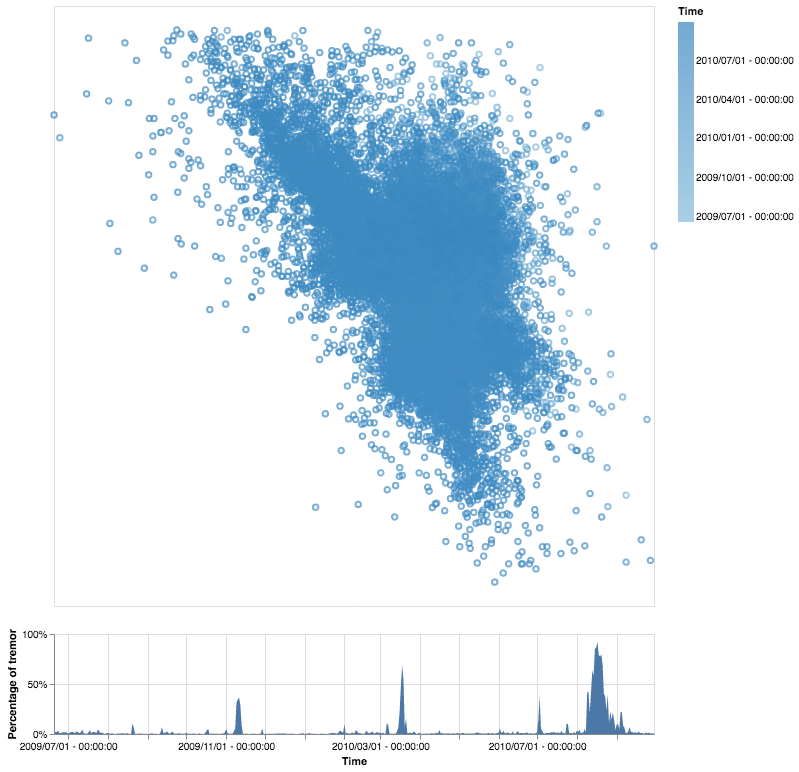

In [8]:
# Selection
brush = alt.selection(type='interval', encodings=['x'])
# Map of tremor location
points = alt.Chart(
).mark_point(
).encode(
    longitude = 'longitude',
    latitude = 'latitude',
    color=alt.Color('Time', \
                    legend=alt.Legend(format='%Y/%m/%d - %H:%M:%S'))
).transform_filter(
    brush.ref()
).properties(
    width=600,
    height=600
)
# Graph of tremor activity
bars = alt.Chart(
).mark_area(
).encode(
    x=alt.X('Time', \
            axis=alt.Axis(format='%Y/%m/%d - %H:%M:%S', title='Time')),
    y=alt.Y('Value', \
            axis=alt.Axis(format='%', title='Percentage of tremor'))
).properties(
    width=600,
    height=100,
    selection=brush
)
# Putting graphs together
myChart = alt.vconcat(points, bars, data=tremors)
myChart

Read background map

In [9]:
subdata = read_background('../data/WA_BC_Plus_shoreline.shp', \
    tremors['latitude'].min(), tremors['latitude'].max(), \
    tremors['longitude'].min(), tremors['longitude'].max())

In [10]:
fp = '../data/WA_BC_Plus_shoreline.shp'
data = gpd.read_file(fp)
data.rename(columns={'id' : 'id0'}, inplace=True)
latmin = tremors['latitude'].min()
latmax = tremors['latitude'].max()
lonmin = tremors['longitude'].min()
lonmax = tremors['longitude'].max()
limits = gpd.GeoSeries([Polygon([(lonmin, latmin), (lonmax, latmin), (lonmax, latmax), (lonmin, latmax)])])
boundaries = gpd.GeoDataFrame({'geometry': limits, 'df':[1]}, crs=data.crs)
subdata = gpd.overlay(data, boundaries, how='intersection')

Plot with background map

In [11]:
alt.Chart(subdata).mark_geoshape(
).project(
).encode(
    color=alt.value('white')
).properties(
).configure(
    background='lightblue'
)

TypeError: __init__() got an unexpected keyword argument 'orient'

Chart({
  config: Config({
    background: 'lightblue'
  }),
  data:         id0  level source  parent_id  sibling_id          area  df  \
  0         2      1    WVS         -1           2  2.015474e+07   1   
  1        50      1    WVS         -1          50  3.205080e+04   1   
  2       551      1    WVS         -1         551  4.552619e+02   1   
  3       986      1    WVS         -1         986  1.923893e+02   1   
  4      1143      1    WVS         -1        1143  1.550509e+02   1   
  5      1174      1    WVS         -1        1174  1.486728e+02   1   
  6      1531      1    WVS         -1        1531  9.843258e+01   1   
  7      1714      1    WVS         -1        1714  8.222738e+01   1   
  8      1821      1    WVS         -1        1821  7.452435e+01   1   
  9      2249      1  WDBII         -1        2249  5.037556e+01   1   
  10     3025      1    WVS         -1        3025  3.052348e+01   1   
  11     3065      1    WVS         -1        3065  2.992905e+01   1 

In [12]:
bgmap = alt.Chart(subdata).mark_geoshape(
).project(
).encode(
    color=alt.value('white')
).properties(
)

points = alt.Chart(tremors).mark_point().encode(
    longitude = 'longitude',
    latitude = 'latitude',
    color=alt.Color('Time', legend=alt.Legend(format='%Y/%m/%d - %H:%M:%S'))
).properties(
    width=600,
    height=600
)

alt.layer(bgmap, points).configure(background='lightblue')

TypeError: __init__() got an unexpected keyword argument 'orient'

LayerChart({
  config: Config({
    background: 'lightblue'
  }),
  layer: [Chart({
    data:         id0  level source  parent_id  sibling_id          area  df  \
    0         2      1    WVS         -1           2  2.015474e+07   1   
    1        50      1    WVS         -1          50  3.205080e+04   1   
    2       551      1    WVS         -1         551  4.552619e+02   1   
    3       986      1    WVS         -1         986  1.923893e+02   1   
    4      1143      1    WVS         -1        1143  1.550509e+02   1   
    5      1174      1    WVS         -1        1174  1.486728e+02   1   
    6      1531      1    WVS         -1        1531  9.843258e+01   1   
    7      1714      1    WVS         -1        1714  8.222738e+01   1   
    8      1821      1    WVS         -1        1821  7.452435e+01   1   
    9      2249      1  WDBII         -1        2249  5.037556e+01   1   
    10     3025      1    WVS         -1        3025  3.052348e+01   1   
    11     3065      1

In [13]:
brush = alt.selection(type='interval', encodings=['x'])

bgmap = alt.Chart(subdata).mark_geoshape(
).project(
).encode(
    color=alt.value('white')
).properties(
)

points = alt.Chart(tremors).mark_point().encode(
    longitude = 'Longitude',
    latitude = 'Latitude',
    color=alt.Color('Time', legend=alt.Legend(format='%Y/%m/%d - %H:%M:%S'))
)

bgpoints = alt.layer(bgmap, points).transform_filter(
    brush.ref()
).properties(
    width=600,
    height=600
)

bars = alt.Chart(tremors).mark_area().encode(
    x=alt.X('Time', axis=alt.Axis(format='%Y/%m/%d - %H:%M:%S', title='Time')),
    y=alt.Y('Value', axis=alt.Axis(format='%', title='Percentage of tremor'))
).properties(
    width=600,
    height=100,
    selection=brush
)

alt.vconcat(bgpoints, bars).configure(background='lightblue')

TypeError: __init__() got an unexpected keyword argument 'orient'

VConcatChart({
  config: Config({
    background: 'lightblue'
  }),
  vconcat: [LayerChart({
    height: 600,
    layer: [Chart({
      data:         id0  level source  parent_id  sibling_id          area  df  \
      0         2      1    WVS         -1           2  2.015474e+07   1   
      1        50      1    WVS         -1          50  3.205080e+04   1   
      2       551      1    WVS         -1         551  4.552619e+02   1   
      3       986      1    WVS         -1         986  1.923893e+02   1   
      4      1143      1    WVS         -1        1143  1.550509e+02   1   
      5      1174      1    WVS         -1        1174  1.486728e+02   1   
      6      1531      1    WVS         -1        1531  9.843258e+01   1   
      7      1714      1    WVS         -1        1714  8.222738e+01   1   
      8      1821      1    WVS         -1        1821  7.452435e+01   1   
      9      2249      1  WDBII         -1        2249  5.037556e+01   1   
      10     3025      1    